In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import audioread
from pydub import AudioSegment
import soundfile as sf
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Data Preprocessing


 Loading metadata

In [2]:
sentence_df = pd.read_csv('./CREMA-D-master/SentenceFilenames.csv')
demographics_df = pd.read_csv('./CREMA-D-master/VideoDemographics.csv')
ratings_df = pd.read_csv('./CREMA-D-master/processedResults/tabulatedVotes.csv')


In [3]:
print("Sentence Data:\n", sentence_df.head())
print("\nDemographics:\n", demographics_df.head())
print("\nRatings:\n", ratings_df.head())

Sentence Data:
    Stimulus_Number         Filename
0                1  1001_IEO_NEU_XX
1                2  1001_IEO_HAP_LO
2                3  1001_IEO_HAP_MD
3                4  1001_IEO_HAP_HI
4                5  1001_IEO_SAD_LO

Demographics:
    ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic

Ratings:
    Unnamed: 0  A  D  F  H   N  S         fileName  numResponses  agreement  \
0      100001  0  0  0  1  10  0  1001_IEO_NEU_XX            11   0.909091   
1      100002  0  0  0  3   6  0  1001_IEO_HAP_LO             9   0.666667   
2      100003  0  0  0  4   7  0  1001_IEO_HAP_MD            11   0.636364   
3      100004  2  0  0  6   2  0  1001_IEO_HAP_HI            10   0.600000   
4      100005  

Loading Audio files

In [4]:
import os

audio_folder = './CREMA-D-master/AudioWAV/'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]
print(f"Total audio files found: {len(audio_files)}")


Total audio files found: 7443


In [5]:
def extract_features(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=16000)  # Resampling to 16kHz
        
        # MFCCs (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Pitch (Fundamental Frequency F0)
        f0, voiced_flag, _ = librosa.pyin(y, fmin=50, fmax=300)
        f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0

        # RMS Energy
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)

        return [file_path, *mfccs_mean, f0_mean, rms_mean, zcr_mean]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Create an empty list to store features
features_list = []

# Process all audio files
for file in audio_files:
    file_path = os.path.join(audio_folder, file)
    features = extract_features(file_path)
    if features:
        features_list.append(features)

# Convert to Pandas DataFrame
columns = ["filename"] + [f"mfcc_{i}" for i in range(40)] + ["f0_mean", "rms_mean", "zcr_mean"]
df_features = pd.DataFrame(features_list, columns=columns)

# Save extracted features to a CSV file
df_features.to_csv("audio_features.csv", index=False)
print("Feature extraction completed and saved to audio_features.csv!")


/tmp/ipykernel_11149/3135516346.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=16000)  # Resampling to 16kHz
/home/gen/projects/AI-Based-Public-Speaking-Feedback-System/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing ./CREMA-D-master/AudioWAV/1040_ITH_SAD_XX.wav: 
Feature extraction completed and saved to audio_features.csv!


Compute clarity features:

In [7]:
df_features = pd.read_csv("./audio_features.csv")
df_features.head()

,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,f0_mean,rms_mean,zcr_mean
0,./CREMA-D-master/AudioWAV/1059_IEO_DIS_HI.wav,-361.25378,108.742950,31.540785,13.416340,8.614111,3.628117,2.050298,-2.968109,-2.159094,...,3.079687,1.296834,-3.559864,0.681434,-2.462368,-3.407840,-1.179454,0.000000,0.014453,0.093305
1,./CREMA-D-master/AudioWAV/1036_TAI_ANG_XX.wav,-299.55716,104.236786,30.624527,34.266838,-4.763363,-16.407686,-0.749678,-12.281210,-6.176827,...,0.172587,-0.334308,-0.489977,2.760211,1.932183,1.583761,2.163952,272.060282,0.073582,0.077727
2,./CREMA-D-master/AudioWAV/1029_IOM_HAP_XX.wav,-344.61185,88.496124,21.919884,37.154080,4.626700,-3.954267,2.161982,-10.820110,-1.182033,...,1.629210,0.969945,-0.759939,0.583013,-0.949163,-2.515619,-4.221344,258.325798,0.023923,0.075157
3,./CREMA-D-master/AudioWAV/1016_TIE_FEA_XX.wav,-323.25107,105.985010,26.437527,26.433258,10.218193,-3.218624,-6.988673,-6.257297,2.342243,...,0.379818,-1.407131,0.344147,-0.327345,0.061354,-0.596730,-0.932904,0.000000,0.032986,0.078050
4,./CREMA-D-master/AudioWAV/1024_IEO_DIS_LO.wav,-401.54870,110.927000,42.156430,19.019499,13.172677,8.222682,6.693701,-1.888703,-2.463243,...,3.827492,0.991335,1.852242,0.481349,1.390641,1.577273,-1.457861,257.136765,0.007906,0.067263


In [8]:
def calculate_mfcc_variance(df):
    mfcc_columns = [f"mfcc_{i}" for i in range(40)]
    df['mfcc_variance'] = df[mfcc_columns].var(axis=1)
    return df

def calculate_spectral_centroid(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        return np.mean(spectral_centroid)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

# Add Spectral Centroid to the DataFrame
df_features['spectral_centroid'] = df_features['filename'].apply(calculate_spectral_centroid)


# Let's assume it's proportional to the RMS energy variation.
def calculate_articulation_rate(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        rms = librosa.feature.rms(y=y)
        articulation_rate = np.mean(rms)  # Simplified as RMS mean
        return articulation_rate
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

# Add Articulation Rate to the DataFrame
df_features['articulation_rate'] = df_features['filename'].apply(calculate_articulation_rate)

# Calculate MFCC Variance
df_features = calculate_mfcc_variance(df_features)

# Display updated DataFrame with clarity features
df_features.head()


,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_36,mfcc_37,mfcc_38,mfcc_39,f0_mean,rms_mean,zcr_mean,spectral_centroid,articulation_rate,mfcc_variance
0,./CREMA-D-master/AudioWAV/1059_IEO_DIS_HI.wav,-361.25378,108.742950,31.540785,13.416340,8.614111,3.628117,2.050298,-2.968109,-2.159094,...,0.681434,-2.462368,-3.407840,-1.179454,0.000000,0.014453,0.093305,1509.038851,0.014453,3656.626261
1,./CREMA-D-master/AudioWAV/1036_TAI_ANG_XX.wav,-299.55716,104.236786,30.624527,34.266838,-4.763363,-16.407686,-0.749678,-12.281210,-6.176827,...,2.760211,1.932183,1.583761,2.163952,272.060282,0.073582,0.077727,1401.751393,0.073582,2636.893057
2,./CREMA-D-master/AudioWAV/1029_IOM_HAP_XX.wav,-344.61185,88.496124,21.919884,37.154080,4.626700,-3.954267,2.161982,-10.820110,-1.182033,...,0.583013,-0.949163,-2.515619,-4.221344,258.325798,0.023923,0.075157,1546.516544,0.023923,3278.274282
3,./CREMA-D-master/AudioWAV/1016_TIE_FEA_XX.wav,-323.25107,105.985010,26.437527,26.433258,10.218193,-3.218624,-6.988673,-6.257297,2.342243,...,-0.327345,0.061354,-0.596730,-0.932904,0.000000,0.032986,0.078050,1351.148184,0.032986,2989.843770
4,./CREMA-D-master/AudioWAV/1024_IEO_DIS_LO.wav,-401.54870,110.927000,42.156430,19.019499,13.172677,8.222682,6.693701,-1.888703,-2.463243,...,0.481349,1.390641,1.577273,-1.457861,257.136765,0.007906,0.067263,1322.108382,0.007906,4488.400117


Data Cleaning

filename    0
mfcc_0      0
mfcc_1      0
mfcc_2      0
mfcc_3      0
mfcc_4      0
mfcc_5      0
mfcc_6      0
mfcc_7      0
mfcc_8      0
mfcc_9      0
mfcc_10     0
mfcc_11     0
mfcc_12     0
mfcc_13     0
mfcc_14     0
mfcc_15     0
mfcc_16     0
mfcc_17     0
mfcc_18     0
mfcc_19     0
mfcc_20     0
mfcc_21     0
mfcc_22     0
mfcc_23     0
mfcc_24     0
mfcc_25     0
mfcc_26     0
mfcc_27     0
mfcc_28     0
mfcc_29     0
mfcc_30     0
mfcc_31     0
mfcc_32     0
mfcc_33     0
mfcc_34     0
mfcc_35     0
mfcc_36     0
mfcc_37     0
mfcc_38     0
mfcc_39     0
f0_mean     0
rms_mean    0
zcr_mean    0
dtype: int64
            mfcc_0       mfcc_1       mfcc_2       mfcc_3       mfcc_4  \
count  7442.000000  7442.000000  7442.000000  7442.000000  7442.000000   
mean   -351.141613   101.387476    32.527496    22.956191     5.605276   
std      54.715606    14.333944    14.050444     7.298027     8.606121   
min   -1131.371000     0.000000   -21.610441    -8.914307   -32.680990   
2

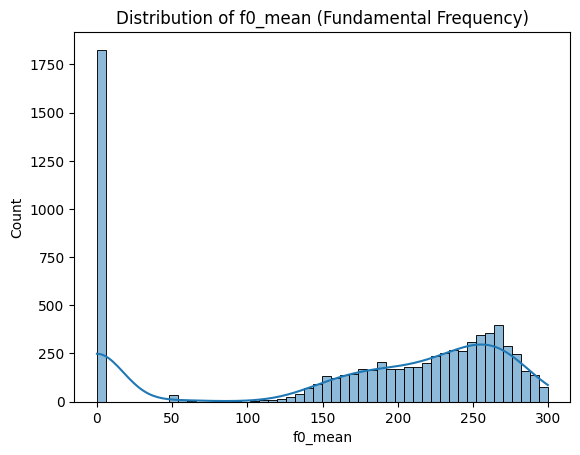

In [9]:
df = pd.read_csv("./audio_features.csv")

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Check correlations
df_numeric = df.drop(columns=['filename'])  # Remove filename column
correlation_matrix = df_numeric.corr()  # Compute correlation matrix
print(correlation_matrix)

# Visualizing feature distributions

sns.histplot(df['f0_mean'], bins=50, kde=True)
plt.title("Distribution of f0_mean (Fundamental Frequency)")
plt.show()


In [10]:
# Drop filename for numerical analysis
df_numeric = df.drop(columns=['filename'])

# Identify rows with zero pitch or energy
zero_pitch = df_numeric[df_numeric['f0_mean'] == 0]
zero_energy = df_numeric[df_numeric['rms_mean'] == 0]

print(f"Zero Pitch Count: {len(zero_pitch)}")
print(f"Zero Energy Count: {len(zero_energy)}")

# Detect outliers using IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()
print("\nOutlier Count per Feature:")
print(outliers)


Zero Pitch Count: 1827
Zero Energy Count: 1

Outlier Count per Feature:
mfcc_0      137
mfcc_1      239
mfcc_2       76
mfcc_3       87
mfcc_4      136
mfcc_5       69
mfcc_6       97
mfcc_7       71
mfcc_8      148
mfcc_9      222
mfcc_10     106
mfcc_11     403
mfcc_12     147
mfcc_13     135
mfcc_14     275
mfcc_15     203
mfcc_16     150
mfcc_17     206
mfcc_18     238
mfcc_19     223
mfcc_20     261
mfcc_21     422
mfcc_22     207
mfcc_23     263
mfcc_24     237
mfcc_25     218
mfcc_26     219
mfcc_27     221
mfcc_28     172
mfcc_29     139
mfcc_30     183
mfcc_31     210
mfcc_32     174
mfcc_33     132
mfcc_34     154
mfcc_35     147
mfcc_36      94
mfcc_37     132
mfcc_38     157
mfcc_39     116
f0_mean       0
rms_mean    710
zcr_mean    432
dtype: int64


In [11]:
# Replace zero values in 'f0_mean' with the minimum non-zero pitch
min_f0 = df[df['f0_mean'] > 0]['f0_mean'].min()
df['f0_mean'] = df['f0_mean'].replace(0, min_f0)

# Alternatively, replace zero values in 'rms_mean' with the minimum non-zero RMS value
min_rms = df[df['rms_mean'] > 0]['rms_mean'].min()
df['rms_mean'] = df['rms_mean'].replace(0, min_rms)

# Define a function to filter out outliers based on IQR
def filter_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
#df_filtered = filter_outliers(df, df.columns[1:])

def cap_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.85):
    for col in cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Apply filtering on MFCCs and other features with potential outliers
df_filtered = cap_outliers(df, df.columns[1:])  # Filtering all feature columns (excluding 'filename')


Original dataset shape: (7442, 44)
Filtered dataset shape: (7442, 44)


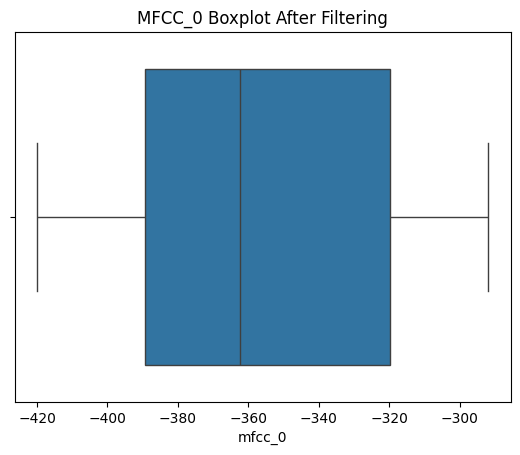

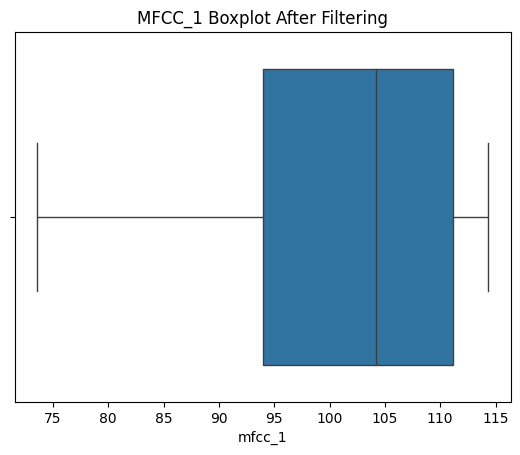

In [12]:
# Before filtering
print(f"Original dataset shape: {df.shape}")

# After filtering
print(f"Filtered dataset shape: {df_filtered.shape}")
sns.boxplot(x=df_filtered['mfcc_0'])
plt.title('MFCC_0 Boxplot After Filtering')
plt.show()

# Repeat for other features if needed
sns.boxplot(x=df_filtered['mfcc_1'])
plt.title('MFCC_1 Boxplot After Filtering')
plt.show()

Confidence features

In [13]:
# Calculate pitch variation (standard deviation of F0)
df_filtered['pitch_variation'] = df_filtered['f0_mean'].std()

# Calculate energy stability (standard deviation of RMS energy)
df_filtered['energy_stability'] = df_filtered['rms_mean'].std()


Fluency features

In [14]:
# Define a threshold for detecting pauses (e.g., RMS <= 0.01 is a pause)
pause_threshold = 0.01
df_filtered['pause_frequency'] = (df_filtered['rms_mean'] <= pause_threshold).sum()

# Calculate pause duration as the number of consecutive RMS values below the threshold
df_filtered['pause_duration'] = df_filtered['rms_mean'][df_filtered['rms_mean'] <= pause_threshold].count()

# Calculate speaking rate as the number of non-zero RMS values
df_filtered['speaking_rate'] = (df_filtered['rms_mean'] > pause_threshold).sum()


In [15]:
print(df_filtered[['filename', 'pitch_variation', 'energy_stability', 'pause_frequency', 'pause_duration', 'speaking_rate']].head())

                                        filename  pitch_variation  \
0  ./CREMA-D-master/AudioWAV/1059_IEO_DIS_HI.wav        83.123862   
1  ./CREMA-D-master/AudioWAV/1036_TAI_ANG_XX.wav        83.123862   
2  ./CREMA-D-master/AudioWAV/1029_IOM_HAP_XX.wav        83.123862   
3  ./CREMA-D-master/AudioWAV/1016_TIE_FEA_XX.wav        83.123862   
4  ./CREMA-D-master/AudioWAV/1024_IEO_DIS_LO.wav        83.123862   

   energy_stability  pause_frequency  pause_duration  speaking_rate  
0          0.014236             1416            1416           6026  
1          0.014236             1416            1416           6026  
2          0.014236             1416            1416           6026  
3          0.014236             1416            1416           6026  
4          0.014236             1416            1416           6026  


# Data Training #

PCA to reduce dimensionality

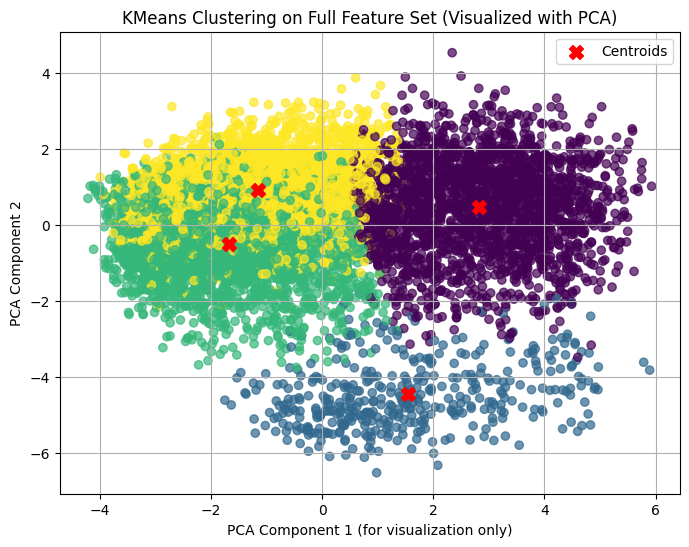

0.4496092567985612


In [ ]:
# 1. Select features (no PCA here)
columns_for_clustering = ['mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
                          'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14',
                          'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'f0_mean',
                          'rms_mean', 'zcr_mean']

# 2. Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_filtered[columns_for_clustering])

# 3. Apply KMeans directly on the scaled features
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# 4. Add cluster labels back to the DataFrame
df_filtered['cluster'] = clusters

# 5. Use PCA to simplify data so it can be plotted
from sklearn.decomposition import PCA
pca_vis = PCA(n_components=2)
vis_components = pca_vis.fit_transform(scaled_data)

# 6. Plot with clusters (on 2D PCA just for visualization)
plt.figure(figsize=(8,6))
plt.scatter(vis_components[:, 0], vis_components[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1 (for visualization only)')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering on Full Feature Set (Visualized with PCA)')
plt.grid(True)

# Optional: Show cluster centers projected into 2D PCA space
centers_2d = pca_vis.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=100, marker='X', label='Centroids')
plt.legend()
plt.show()

In [ ]:
# classify the three clusters
df_filtered.groupby('cluster')[['f0_mean', 'rms_mean', 'zcr_mean']].mean()


,f0_mean,rms_mean,zcr_mean
cluster,,,
0,205.427006,0.041318,0.092100
1,162.477472,0.020368,0.093295
2,199.681144,0.013280,0.073508
3,140.667448,0.015727,0.068873


##### Since cluster 0 has high and energy, and high chopiness, it will be labelled as moderate.
##### Since cluster 1 has the highest chopiness, and moderate energy, it will be labelled as hesitant.
##### Since cluster 2 has low energy, and moderate smoothness, it will be labelled as fluent.
##### Since cluster 3 has low energy and low smoothness, it will be classified as monotone.

Train-test split

In [ ]:
features = ['mfcc_' + str(i) for i in range(21)] + ['f0_mean', 'rms_mean', 'zcr_mean']
X = df_filtered[features]
y = df_filtered['cluster']

# split the data into 20% test and 80% validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [65]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'fluency_classifier.pkl')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


['fluency_classifier.pkl']

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       438
           1       1.00      0.89      0.94        85
           2       0.93      0.94      0.94       500
           3       0.93      0.92      0.93       466

    accuracy                           0.94      1489
   macro avg       0.95      0.93      0.94      1489
weighted avg       0.94      0.94      0.94      1489



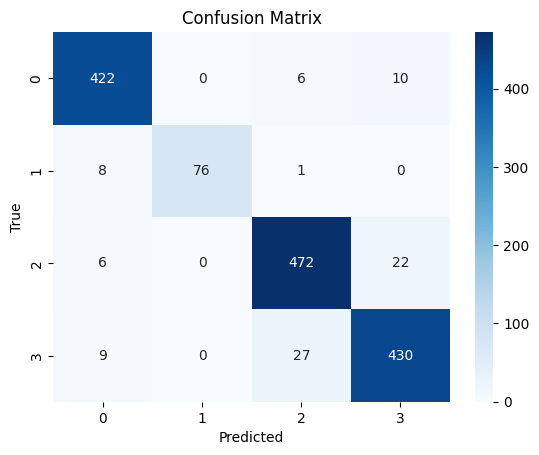

In [66]:
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()